# Human-in-the-Loop (HITL) Email Agent using LangGraph and Qubrid AI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QubridAI-Inc/qubrid-cookbook/blob/main/Notebooks/Email_Agent_with_HITL.ipynb)

![Qubrid x Langgraph](../../qubrid-cookbook/Assets/Images/Langgraph_x_Qubrid.png)

This notebook shows how to build a Human-in-the-Loop (HITL) email assistant using LangGraph and Qubrid AI. The agent can draft and refine emails, but the final send action is strictly gated by explicit human approval.

- **GPT-OSS-120B** on the Qubrid AI Platform for high-quality reasoning, email drafting, and feedback handling

- **LangGraph Interrupt & Resume** patterns to enforce a mandatory human approval checkpoint

- **Hybrid state management** to persist and evolve an email draft across multiple interaction turns

**Pattern:**
```
User Request → Draft/Update → [Loop: Iterative Feedback] → Human Approval → Send Email

### The Pattern You'll Master

![Workflow Diagram](../../qubrid-cookbook/Assets/Images/hitl.png)

Let's begin! 🚀

## 1. Environment Setup
Initialize the development environment by setting up the orchestration stack and authenticating with the Qubrid AI Platform.

- **Core Orchestration**: LangGraph and LangChain for building stateful, multi-turn agent workflows.
- **Qubrid AI Integration**: Configure `QUBRID_API_KEY` to access high-performance inference for **GPT-OSS-120b**.
- **Environment Agnostic**: Support for both Local (`.env`) and Google Colab (`userdata`) authentication.

In [1]:
!uv pip install -U langgraph langchain_core requests python-dotenv

Using Python 3.12.12 environment at: /usr
Resolved 32 packages in 430ms
Prepared 8 packages in 140ms
Uninstalled 8 packages in 34ms
Installed 8 packages in 11ms
 - langchain-core==1.2.7
 + langchain-core==1.2.8
 - langsmith==0.6.6
 + langsmith==0.6.8
 - orjson==3.11.5
 + orjson==3.11.7
 - packaging==25.0
 + packaging==26.0
 - pydantic==2.12.3
 + pydantic==2.12.5
 - pydantic-core==2.41.4
 + pydantic-core==2.41.5
 - requests==2.32.4
 + requests==2.32.5
 - urllib3==2.5.0
 + urllib3==2.6.3


In [2]:
# 1. Imports and Environment Setup
import os
import requests
import json
import re
from typing import List, Optional, Any, TypedDict, Annotated
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
)
from langchain_core.outputs import ChatResult, ChatGeneration
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from pydantic import Field
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

# Load API Key
try:
    from google.colab import userdata
    QUBRID_API_KEY = userdata.get("QUBRID_API_KEY")
    print("Environment: Google Colab")
except ImportError:
    from dotenv import load_dotenv
    load_dotenv()
    QUBRID_API_KEY = os.getenv("QUBRID_API_KEY")
    print("Environment: Local")

if not QUBRID_API_KEY:
    raise ValueError("QUBRID_API_KEY not found!")

Environment: Google Colab


## 2. Setting up the LLM Client
We implement a custom LangChain wrapper for the **gpt-oss-120b** model on Qubrid.

In [3]:
# 2. Custom Qubrid Chat Model (with corrected API parsing)
class ChatQubrid(BaseChatModel):
    """Qubrid Chat Model with corrected API response parsing."""

# Qubrid model configuration and generation parameters
    api_key: str = Field(...)
    base_url: str = "https://platform.qubrid.com/api/v1/qubridai/chat/completions"
    model_name: str = "openai/gpt-oss-120b"
    temperature: float = 0.5
    max_tokens: int = 2000
    tools: Optional[List[dict]] = None

# Identifies this custom model type for LangChain internals
    @property
    def _llm_type(self) -> str:
        return "qubrid-chat-model"

# Core generation method required by BaseChatModel.
# Translates LangChain messages → Qubrid API payload
# and converts Qubrid responses → LangChain ChatResult.
    def _generate(self, messages: List[BaseMessage], stop: Optional[List[str]] = None, **kwargs: Any) -> ChatResult:
# Authorization and content headers for Qubrid Chat Completion API
        headers = {"Authorization": f"Bearer {self.api_key}", "Content-Type": "application/json"}

        # Convert LangChain message objects into OpenAI-compatible
        # role/content format expected by Qubrid API
        payload_messages = []
        for m in messages:
            role = "user"
            if isinstance(m, HumanMessage): role = "user"
            elif isinstance(m, AIMessage): role = "assistant"
            elif isinstance(m, ToolMessage): role = "tool"
            elif isinstance(m, SystemMessage): role = "system"

            msg_dict = {"role": role, "content": str(m.content)}
            # Required to correctly associate tool responses with tool calls
            if isinstance(m, ToolMessage):
                msg_dict["tool_call_id"] = m.tool_call_id
            # Preserve tool call metadata for multi-step tool execution
            if isinstance(m, AIMessage) and "tool_calls" in m.additional_kwargs:
                msg_dict["tool_calls"] = m.additional_kwargs["tool_calls"]
            payload_messages.append(msg_dict)

        # Final request payload sent to Qubrid chat completion endpoint
        payload = {
            "model": self.model_name,
            "messages": payload_messages,
            "temperature": self.temperature,
            "max_tokens": self.max_tokens,
            "stream": False
        }

        # Attach tool schemas when the model is tool-enabled (agent mode)
        if self.tools:
            payload["tools"] = self.tools

        # Execute synchronous request to Qubrid API and fail fast on HTTP errors
        res = requests.post(self.base_url, headers=headers, json=payload, timeout=60)
        res.raise_for_status()
        data = res.json()

        # Qubrid response parsing:
        # - `content` holds the assistant text output
        # - `tool_calls` contains structured function/tool invocations (if any)
        content = data.get("content") or ""
        raw_tool_calls = data.get("tool_calls") or []

        # Normalize tool calls into LangChain-compatible format
        tool_calls = []
        for tc in raw_tool_calls:
            tool_calls.append({
                "name": tc["function"]["name"],
                "args": json.loads(tc["function"]["arguments"]),
                "id": tc["id"]
            })

        # Create LangChain AIMessage with both text output and tool calls
        ai_msg = AIMessage(content=content, tool_calls=tool_calls)
        if raw_tool_calls:
            ai_msg.additional_kwargs["tool_calls"] = raw_tool_calls

        # Wrap the AI message in LangChain's ChatResult container
        return ChatResult(generations=[ChatGeneration(message=ai_msg)])

    # Enables tool binding by converting LangChain tools
    # into OpenAI-compatible tool schemas for Qubrid
    def bind_tools(self, tools: List[Any], **kwargs: Any) -> Any:
        new_instance = self.model_copy()
        new_instance.tools = [convert_to_openai_tool(t) for t in tools]
        return new_instance

llm = ChatQubrid(api_key=QUBRID_API_KEY)

## 3. Agent State and Tool Definitions

In [4]:
# Agent State Definition

# Represents the structured email draft maintained across turns.
# `total=False` allows partial updates (e.g., only body changes).
class EmailDraft(TypedDict, total=False):
    recipient: str
    subject: str
    body: str


# Shared agent state passed between LangGraph nodes.
class AgentState(TypedDict):
    # Conversation history managed by LangGraph.
    # `add_messages` automatically appends new messages to state.
    messages: Annotated[list[BaseMessage], add_messages]

    # The current working email draft.
    draft: EmailDraft

    # Controls graph flow (e.g., "draft", "approve", "send").
    next_action: Optional[str]

# Tool Definitions
@tool
def update_email_draft(recipient: str, subject: str, body: str) -> str:
    """
    Updates the email draft stored in agent state.

    This tool is used during the drafting and refinement loop
    and does NOT send the email.
    """
    return f"✅ Draft updated: {recipient} | {subject}"


@tool
def send_email(recipient: str, subject: str, body: str) -> str:
    """
    Executes the final email send action.

    This tool should only be callable after passing
    the Human-in-the-Loop (HITL) approval gate.
    """
    return f"📧 Email sent to {recipient}!"


# Register all tools available to the agent.
# `send_email` is intentionally gated by human approval in the graph.
tools = [update_email_draft, send_email]

## 4. Helper Utilities & Decision Logic
This section contains the pattern-matching utilities that extract email drafts from structured text and detect when the agent intends to "send" the communication.

In [5]:
# 4. Graph Implementation
SYSTEM_PROMPT = """You are an Email Assistant. Help the user draft emails.

When the user asks you to draft or update an email, respond with:
1. A conversational message
2. The email details in this EXACT format:

DRAFT:
To: [email]
Subject: [subject]
Body: [body text]

When the user says \"send it\" or \"send now\", respond with:
SEND: yes

Be helpful and conversational."""

llm_with_tools = llm.bind_tools(tools)

def extract_draft_from_text(content: str) -> Optional[EmailDraft]:
    """Extract email draft from model's text response."""
    if "DRAFT:" not in content:
        return None
    draft = {}
    to_match = re.search(r'To:\s*([^\n]+)', content)
    if to_match: draft["recipient"] = to_match.group(1).strip()
    subj_match = re.search(r'Subject:\s*([^\n]+)', content)
    if subj_match: draft["subject"] = subj_match.group(1).strip()
    body_match = re.search(r'Body:\s*(.+?)(?=\n\n|$)', content, re.DOTALL)
    if body_match: draft["body"] = body_match.group(1).strip()
    return draft if draft else None

def should_send(content: str) -> bool:
    return "SEND: yes" in content or "send it" in content.lower()

## 5. Defining Agent Nodes
These functions represent the nodes of our graph. They receive the current state, perform a transformation (like invoking the LLM or prompting for human feedback), and return the updated state.



In [6]:
llm_with_tools = llm.bind_tools(tools)

def model_node(state: AgentState):
    """Processes user input, updates the draft, and determines the next action."""
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    response = llm_with_tools.invoke(messages)

    draft_update = state.get("draft", {})
    if response.tool_calls:
        for tc in response.tool_calls:
            if tc["name"] in ["update_email_draft", "send_email"]:
                draft_update = {**draft_update, **tc["args"]}
    else:
        extracted = extract_draft_from_text(response.content)
        if extracted: draft_update = {**draft_update, **extracted}

    next_action = "send_email" if should_send(response.content) and draft_update else None
    return {"messages": [response], "draft": draft_update, "next_action": next_action}

def send_email_node(state: AgentState):
    """Secure HITL node. Pauses execution for human approval via interrupt()."""
    draft = state["draft"]
    print("\n" + "="*60 + "\n📧 READY TO SEND EMAIL\n" + "="*60)
    print(f"To: {draft.get('recipient', 'N/A')}\nSubject: {draft.get('subject', 'N/A')}")
    print(f"Body:\n{draft.get('body', 'N/A')[:200]}...\n" + "="*60)

    decision = interrupt("Approve sending this email?")

    if isinstance(decision, str) and decision.lower().strip() == "yes":
        return {"messages": [AIMessage(content="✅ Email sent successfully!")]}
    else:
        return {"messages": [AIMessage(content="❌ Send cancelled. You can continue editing.")]}

def router(state: AgentState):
    """Conditional logic to route to the HITL gate or end the turn."""
    return "send_email" if state.get("next_action") == "send_email" else END

## 6. Graph Compilation & Orchestration
The final step is to assemble the nodes and edges into a stateful workflow. We use a `MemorySaver` to provide persistence, allowing the agent to remember the email draft across multiple user turns.

In [7]:
# 1. Initialize Graph
builder = StateGraph(AgentState)

# 2. Add Nodes
builder.add_node("model", model_node)
builder.add_node("send_email", send_email_node)

# 3. Define Edges & Routing
builder.add_edge(START, "model")
builder.add_conditional_edges(
    "model",
    router,
    {
        "send_email": "send_email",
        END: END
    }
)
builder.add_edge("send_email", END)

# 4. Compile with Persistence
memory = MemorySaver()
chatbot = builder.compile(checkpointer=memory)

print("✅ HITL Email Agent compiled successfully!")

✅ HITL Email Agent compiled successfully!


## Workflow Visualization
The following diagram visualizes the agent's internal state machine. It illustrates the logic flow from user input to the iterative drafting loop, and finally to the mandatory **Human-in-the-Loop Gate** that protects the send sequence.

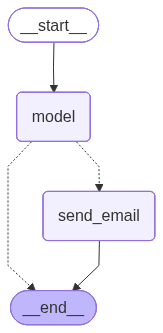

In [8]:
from IPython.display import Image
Image(chatbot.get_graph().draw_mermaid_png())

# 7. Usage Examples

The following cells demonstrate the complete HITL workflow.

**Example 1: Initial Drafting** — The agent creates a structured email draft based on a simple natural language request.

In [9]:
# Example 1: Initial Draft
config = {"configurable": {"thread_id": "demo-session"}}

print("User: Draft an email to john@example.com about onboarding documents\n")
events = chatbot.stream(
    {"messages": [HumanMessage(content="Draft an email to john@example.com about onboarding documents")]},
    config=config,
    stream_mode="values"
)

for event in events:
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}\n")

User: Draft an email to john@example.com about onboarding documents

Assistant: Sure thing! Here’s a draft you can use:

DRAFT:
To: john@example.com
Subject: Onboarding Documents Needed
Body: Hi John,

Welcome aboard! To complete your onboarding process, we’ll need a few documents from you:

- Signed offer letter
- Government‑issued ID (e.g., passport or driver’s license)
- Completed tax forms (W‑4)
- Direct deposit information

If you could send these over by **[insert deadline, e.g., Friday, February 14]**, that would keep everything on track. Feel free to let me know if you have any questions or need assistance with any of the forms.

Thanks, and we look forward to having you on the team!

Best regards,
[Your Name]
[Your Position]
[Your Contact Information]



**Example 2: Iterative Refinement** — Demonstrates the agent's ability to process feedback and update specific draft fields while maintaining conversation state.

In [10]:
# Example 2: Iterative Refinement
print("User: Make it more formal\n")
events = chatbot.stream(
    {"messages": [HumanMessage(content="Make it more formal")]},
    config=config,
    stream_mode="values"
)

for event in events:
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}\n")

User: Make it more formal

Assistant: Sure thing! Here’s a more formal version of the email:

DRAFT:
To: john@example.com
Subject: Submission of Required Onboarding Documentation
Body: Dear Mr. [Last Name],

I hope this message finds you well. In preparation for your upcoming start date with [Company Name], we kindly request that you provide the following onboarding documents at your earliest convenience:

- Signed offer letter  
- Government‑issued identification (e.g., passport or driver’s license)  
- Completed tax forms (e.g., IRS Form W‑4)  
- Direct deposit authorization information  

Please submit the aforementioned items no later than **[insert deadline, e.g., Friday, February 14]** to ensure a seamless transition and timely processing of your employment records. Should you have any questions or require assistance with the documentation, do not hesitate to contact me directly.

Thank you for your prompt attention to this matter. We look forward to welcoming you to the team.

S

**Example 3: Triggering the HITL Gate** — The user requests a high-privilege action ("Send"), causing the graph to pause at a mandatory security interrupt.

In [11]:
# Example 3: Trigger Send (HITL Approval)
print("User: Send it now\n")
events = chatbot.stream(
    {"messages": [HumanMessage(content="Send it now")]},
    config=config,
    stream_mode="values"
)

for event in events:
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}\n")

# Check for interrupt
state = chatbot.get_state(config)
if state.tasks:
    for task in state.tasks:
        if task.interrupts:
            print("⏸️  Execution paused for HITL approval")

User: Send it now

Assistant: SEND: yes


📧 READY TO SEND EMAIL
To: john@example.com
Subject: Submission of Required Onboarding Documentation
Body:
Dear Mr. [Last Name],...
Assistant: SEND: yes

⏸️  Execution paused for HITL approval


**Example 4: Human Authority Approval** — The "Authority" resumes the graph execution with an explicit decision to finalize the workflow.

In [14]:
# Example 4: Human Approval
decision = input("👤 Approve sending? (yes/no): ")
result = chatbot.invoke(Command(resume=decision), config=config)
print(f"\nAssistant: {result['messages'][-1].content}")

👤 Approve sending? (yes/no): yes

Assistant: ❌ Send cancelled. You can continue editing.


**Example 5: Rejection & Revision**
This example demonstrates the full HITL cycle: drafting, requesting to send, human rejection, iterative revision, and final approval.

*Step 1: The agent drafts an email and triggers the "Send" sequence, which hits the mandatory HITL pause.*

In [15]:
# Step 1: Initial Draft and Send Request
config_rejection = {"configurable": {"thread_id": "rejection-session-1"}}
print("User: Draft an email to my manager about the project update\n")
for event in chatbot.stream(
    {"messages": [HumanMessage(content="Draft an email to my manager about the project update")]},
    config=config_rejection, stream_mode="values"
):
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}\n")

print("User: Send it now\n")
for event in chatbot.stream(
    {"messages": [HumanMessage(content="Send it now")]},
    config=config_rejection, stream_mode="values"
):
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}")

# Check if paused
state = chatbot.get_state(config_rejection)
if state.next:
    print(f"\n⏸️  Graph paused at: {state.next}")

User: Draft an email to my manager about the project update

Assistant: Sure thing! Here’s a concise draft you can tweak as needed before sending it to your manager.

DRAFT:
To: manager@example.com
Subject: Project Update – [Project Name] – [Date]
Body: Hi [Manager’s Name],

I wanted to provide a quick update on the [Project Name] as of [Date].

**Progress:**  
- Completed [Milestone/Task 1] and [Milestone/Task 2].  
- Currently on track with [Current Phase/Task], expected to finish by [Target Date].

**Upcoming Work:**  
- Next steps include [Upcoming Task 1] and [Upcoming Task 2].  
- We’re coordinating with [Team/Department] to ensure smooth hand‑off.

**Risks/Issues:**  
- [Brief description of any risk or issue] and our mitigation plan is [Mitigation Strategy].

Please let me know if you’d like more detail on any of these points or have any feedback.

Thanks,  
[Your Name]  
[Your Position]  

Feel free to adjust the placeholders (e.g., manager’s name, project specifics) to fit yo

*Step 2: The human supervisor rejects the action ("no"), causing the agent to safely cancel the send and remain in editing mode.*

In [16]:
# Step 2: Human Authority Rejects
print("Human Authority: no\n")
chatbot.invoke(Command(resume="no"), config=config_rejection)

# Show that the draft is still preserved and we are back in editing
state = chatbot.get_state(config_rejection)
print(f"Assistant: {state.values['messages'][-1].content}")

Human Authority: no


📧 READY TO SEND EMAIL
To: manager@example.com
Subject: Project Update – [Project Name] – [Date]
Body:
Hi [Manager’s Name],...
Assistant: ❌ Send cancelled. You can continue editing.


*Step 3: The user provides corrective feedback to the draft and attempts a second send request.*

In [17]:
# Step 3: User requests revision and tries to send again
print("User: Make it much more formal and add a bullet point about the budget status.\n")
for event in chatbot.stream(
    {"messages": [HumanMessage(content="Make it much more formal and add a bullet point about the budget status.")]},
    config=config_rejection, stream_mode="values"
):
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}\n")

print("User: Okay, send it now\n")
for event in chatbot.stream(
    {"messages": [HumanMessage(content="Okay, send it now")]},
    config=config_rejection, stream_mode="values"
):
    last_msg = event["messages"][-1]
    if isinstance(last_msg, AIMessage) and last_msg.content:
        print(f"Assistant: {last_msg.content}")

# Check for interrupt again
state = chatbot.get_state(config_rejection)
if state.next:
    print(f"\n⏸️  Graph paused for revised approval at: {state.next}")

User: Make it much more formal and add a bullet point about the budget status.

Assistant: Here’s a more formal version with a bullet point for the budget status:

DRAFT:
To: [Manager’s Email]
Subject: Formal Project Update – [Project Name] – [Date]

Body:
Dear [Manager’s Name],

I am writing to provide a comprehensive update on the status of the **[Project Name]** as of **[Date]**.

- **Progress to Date:**  
  • Completion of [Milestone/Task 1] and [Milestone/Task 2].  
  • Current activities focus on [Current Phase/Task], with an anticipated completion date of [Target Date].

- **Budget Status:**  
  • The project remains within the approved budget, with actual expenditures to date totaling **$[Amount]**, representing **[X]%** of the total allocated funds.  
  • Forecasted spend for the remaining phases is **$[Amount]**, and we anticipate no variance beyond the approved contingency.

- **Upcoming Work:**  
  • Planned tasks for the next reporting period include [Upcoming Task 1] and 

*Step 4: The human authority grants final approval ("yes"), allowing the graph to proceed and finalize the action.*

In [18]:
# Step 4: Final Approval
print("Human Authority: yes\n")
result = chatbot.invoke(Command(resume="yes"), config=config_rejection)

print(f"Assistant: {result['messages'][-1].content}")

Human Authority: yes


📧 READY TO SEND EMAIL
To: [Manager’s Email]
Subject: Formal Project Update – [Project Name] – [Date]
Body:
Dear [Manager’s Name],...
Assistant: ✅ Email sent successfully!


**Pattern Architecture:**

`User Prompt` → `[Loop: Draft ↔ Refine]` → `HITL Gate (Interrupt)` → `Human Approval` → `Execute Send`


By leveraging **LangGraph** and **Qubrid AI**, we've built a system that moves beyond simple linear AI scripts to a robust, state-machine architecture:
- **State Persistence**: Maintaining a consistent [EmailDraft](cci:2://file:///Users/kannanpathania/Documents/QubridAI/Second_Notebook/working_hitl_agent.py:124:0-127:13) schema (Recipient, Subject, Body) across multiple turns, even when an action is rejected by the human.
- **Protected Orchestration**: Decoupling the high-intelligence drafting logic from sensitive "Send" actions via a mandatory HITL security gate.
- **Non-Linear Workflows**: Replacing fragile one-step commands with a dynamic feedback loop that routes between drafting, refinement, and final execution.


## Start Building Intelligent Agents ⚡

[🔑 Get Your API Key](https://platform.qubrid.com/signup) ·
[🤖 Explore Available Models](https://docs.platform.qubrid.com/inferencing/Serverless%20Models) ·
[🏏 Try the Playground](https://platform.qubrid.com/playground)

__Build, deploy, and scale agentic workflows with Qubrid AI.__